# 1. Install Necessary Libraries

In [67]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain-community langchain-openai tavily-python

# 2. Import necessary dependencies and set environment variables

In [68]:
import os
import getpass

from langchain_openai import ChatOpenAI

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")


In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini")

# Agentic System

An Agentic System, in the context of AI, refers to a system where one or more Agents are involved. These agents are not just passive entities that respond to commands but exhibit characteristics like:

Autonomy: They can act independently and make decisions.

Proactiveness: They can initiate actions and pursue goals.

Adaptability: They can learn and adapt to changes in their environment.

Goal-Oriented Behavior: They strive to achieve specific objectives or fulfill a particular purpose.

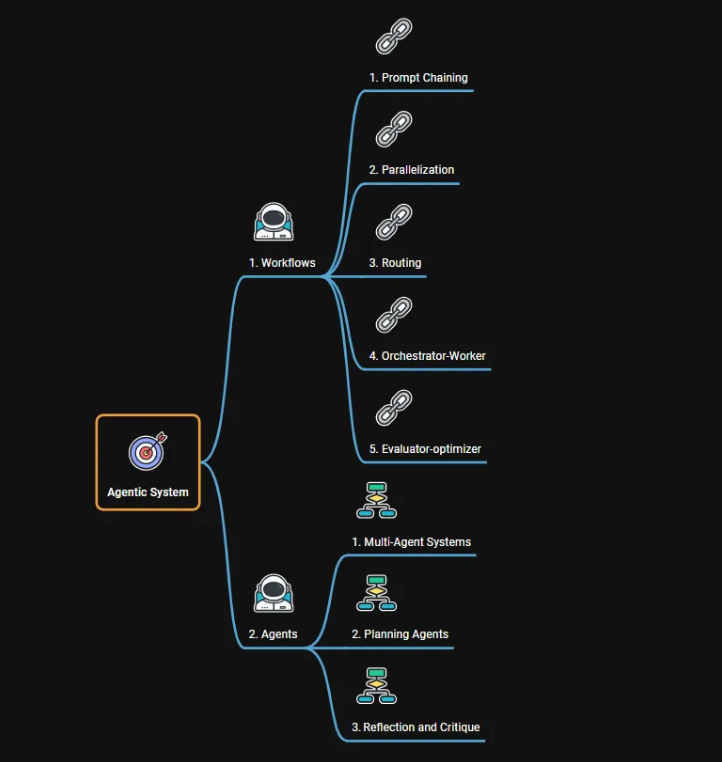

Detailed Blog : https://aiproductplaybook.substack.com/p/101-what-the-heck-are-agentic-system

# 3. Relection and Critique - Reflexion

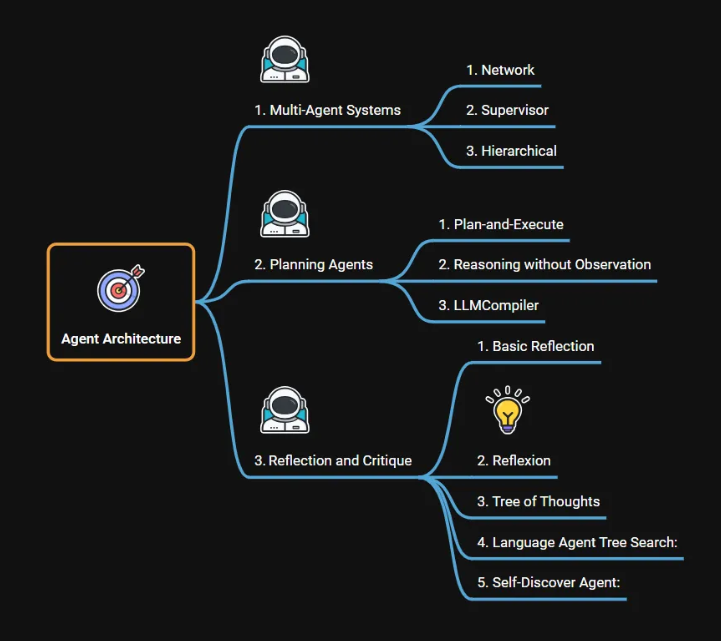

Detailed blog : https://aiproductplaybook.substack.com/p/what-the-heck-are-reflexion-in-agentic

### a. Reflexion

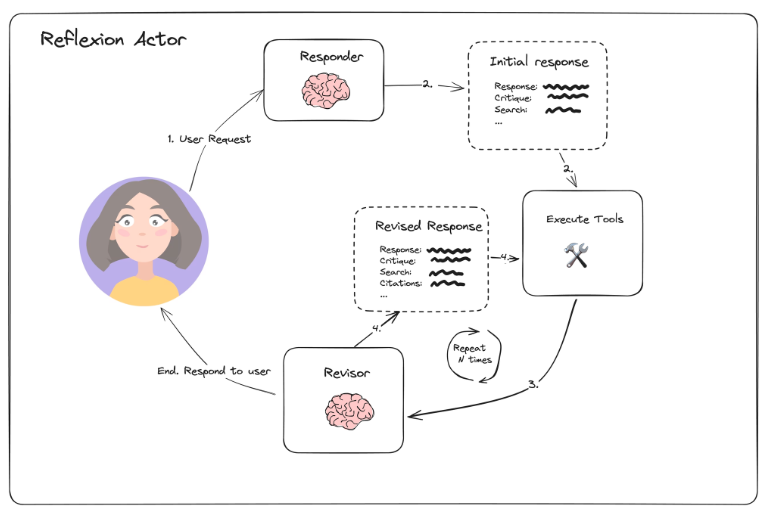

### b. Define our LLM

In [87]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

### c. Define Actor (with reflection)

The main component of Reflexion is the "actor", which is an agent that reflects on its response and re-executes to improve based on self-critique. It's main sub-components include:

1. Tools/tool execution
2. Initial responder: generate an initial response (and self-reflection)
3. Revisor: re-respond (and reflec) based on previous reflections


### Construct the tools

This code sets up a Tavily search tool for LangChain.  It first creates an API wrapper object (search) to handle the details of interacting with the Tavily API. Then, it creates a TavilySearchResults tool (tavily_tool), providing it with the API wrapper and the desired number of results.  The tavily_tool can then be used by LangChain agents to perform web searches using the Tavily API.  The max_results parameter provides a convenient way to limit the number of results returned.

In [81]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper

search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5)

### Define the Initial Responder

1. Import necessary dependencies

2. Reflection Model

Defines a Pydantic model Reflection to structure feedback. It has two fields:

a. missing: Critique of what is missing in the answer.

b. superfluous: Critique of what is unnecessary or extra in the answer.

3. AnswerQuestion Model

Defines a Pydantic model AnswerQuestion to structure the LLM's response. It has three fields:

a. answer: The answer to the question (approximately 250 words).

b. reflection: A Reflection object (using the model defined above) containing critique.

c. search_queries: A list of search queries to improve the answer.

4. ResponderWithRetries Class

a. This class implements a mechanism for retrying LLM calls if the output doesn't conform to the expected Pydantic schema.

b. __init__(self, runnable, validator): The constructor takes:

runnable: The LangChain object (e.g., a chain or agent) that makes the LLM call.

validator: The Pydantic model (AnswerQuestion in this case) used to validate the LLM's output.

c. respond(self, state: dict): This method makes the LLM call and handles retries.

It tries up to 3 times (for attempt in range(3)).

response = self.runnable.invoke(...): Calls the LLM.

try...except ValidationError: Attempts to validate the LLM's output using self.validator.invoke(response).

If validation is successful, it returns the response.

If validation fails (ValidationError), it adds the invalid response and a ToolMessage containing the error message and the schema to the state. This informs the LLM about the validation failure and provides it with the schema so it can correct its output.

After 3 failed attempts, it returns the last (invalid) response.

Summary

This code defines a system for generating answers with reflection and search queries, and implements a retry mechanism to handle validation errors. The Reflection and AnswerQuestion Pydantic models structure the output. The ResponderWithRetries class ensures that the LLM's output conforms to the AnswerQuestion schema by retrying the call up to 3 times if validation fails, providing feedback to the LLM about the schema and errors. This helps to make the LLM's responses more reliable and structured.


In [88]:
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import ValidationError

from pydantic import BaseModel, Field


class Reflection(BaseModel):
    missing: str = Field(description="Critique of what is missing.")
    superfluous: str = Field(description="Critique of what is superfluous")


class AnswerQuestion(BaseModel):
    """Answer the question. Provide an answer, reflection, and then follow up with search queries to improve the answer."""

    answer: str = Field(description="~250 word detailed answer to the question.")
    reflection: Reflection = Field(description="Your reflection on the initial answer.")
    search_queries: list[str] = Field(
        description="1-3 search queries for researching improvements to address the critique of your current answer."
    )


class ResponderWithRetries:
    def __init__(self, runnable, validator):
        self.runnable = runnable
        self.validator = validator

    def respond(self, state: dict):
        response = []
        for attempt in range(3):
            response = self.runnable.invoke(
                {"messages": state["messages"]}, {"tags": [f"attempt:{attempt}"]}
            )
            try:
                self.validator.invoke(response)
                return {"messages": response}
            except ValidationError as e:
                state = state + [
                    response,
                    ToolMessage(
                        content=f"{repr(e)}\n\nPay close attention to the function schema.\n\n"
                        + self.validator.schema_json()
                        + " Respond by fixing all validation errors.",
                        tool_call_id=response.tool_calls[0]["id"],
                    ),
                ]
        return {"messages": response}

This code sets up the initial answer generation process. It defines a prompt template that instructs the LLM to provide an answer, reflect on it, and suggest search queries. The initial_answer_chain combines this prompt with the LLM and the AnswerQuestion tool binding. The first_responder object uses the ResponderWithRetries class to handle potential validation errors in the LLM's output, ensuring that the initial answer conforms to the AnswerQuestion schema. This structure allows for a robust and structured initial answer generation process.

In [90]:
import datetime

actor_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are expert researcher.
Current time: {time}

1. {first_instruction}
2. Reflect and critique your answer. Be severe to maximize improvement.
3. Recommend search queries to research information and improve your answer.""",
        ),
        MessagesPlaceholder(variable_name="messages"),
        (
            "user",
            "\n\n<system>Reflect on the user's original question and the"
            " actions taken thus far. Respond using the {function_name} function.</reminder>",
        ),
    ]
).partial(
    time=lambda: datetime.datetime.now().isoformat(),
)
initial_answer_chain = actor_prompt_template.partial(
    first_instruction="Provide a detailed ~250 word answer.",
    function_name=AnswerQuestion.__name__,
) | llm.bind_tools(tools=[AnswerQuestion])
validator = PydanticToolsParser(tools=[AnswerQuestion])

first_responder = ResponderWithRetries(
    runnable=initial_answer_chain, validator=validator
)

In [91]:
example_question = "Why is reflection useful in AI?"
initial = first_responder.respond(
    {"messages": [HumanMessage(content=example_question)]}
)

### Define the revision step

1. revise_instructions

This string contains the instructions for the LLM on how to revise the answer. Key points:

a. It tells the LLM to use the previous critique to add missing information.

b. Crucially, it mandates the inclusion of numerical citations in the revised answer for verifiability.

c. It specifies the format of the "References" section.

d. It instructs the LLM to remove superfluous information and keep the answer within the 250-word limit.

2. ReviseAnswer Model

a. This defines a new Pydantic model ReviseAnswer that inherits from the AnswerQuestion model (defined in previous code). This means it has all the fields of AnswerQuestion (answer, reflection, search_queries) plus a new field.

b. references: list[str]: This new field is a list of strings, representing the citations for the revised answer.

3. revision_chain

This creates the chain for revising the answer.

actor_prompt_template.partial(...): Fills the placeholders in the actor_prompt_template (defined in previous code):

first_instruction: Sets the instruction to the revise_instructions string.

function_name: Sets the function name to ReviseAnswer.__name__ (which is "ReviseAnswer").

| llm.bind_tools(tools=[ReviseAnswer]): Chains the partially filled prompt with the language model (llm) and, importantly, binds the ReviseAnswer model as a tool. This makes the LLM aware of the ReviseAnswer schema and enables it to structure its output accordingly.

4. revision_validator

Creates a PydanticToolsParser specifically for the ReviseAnswer model. This will be used to validate the LLM's output.

5. revisor

a. Creates an instance of the ResponderWithRetries class. This class (defined in previous code) handles retries if the LLM's output doesn't validate against the Pydantic schema.

b. runnable=revision_chain: Passes the revision_chain to the ResponderWithRetries object.

c. validator=revision_validator: Passes the revision_validator to the ResponderWithRetries object.

summary

This code defines a chain for revising answers.  It uses a specialized prompt that instructs the LLM to add citations and a references section while revising.  The ReviseAnswer Pydantic model extends the original answer schema to include references.  The revision_chain combines the prompt, LLM, and the ReviseAnswer tool binding.  Finally, the revisor object uses the retry mechanism to ensure that the revised answer conforms to the ReviseAnswer schema. This structure helps create a more robust and verifiable revision process.

In [94]:
revise_instructions = """Revise your previous answer using the new information.
    - You should use the previous critique to add important information to your answer.
        - You MUST include numerical citations in your revised answer to ensure it can be verified.
        - Add a "References" section to the bottom of your answer (which does not count towards the word limit). In form of:
            - [1] https://example.com
            - [2] https://example.com
    - You should use the previous critique to remove superfluous information from your answer and make SURE it is not more than 250 words.
"""


# Extend the initial answer schema to include references.
# Forcing citation in the model encourages grounded responses
class ReviseAnswer(AnswerQuestion):
    """Revise your original answer to your question. Provide an answer, reflection,

    cite your reflection with references, and finally
    add search queries to improve the answer."""

    references: list[str] = Field(
        description="Citations motivating your updated answer." , default_factory=list
    )


revision_chain = actor_prompt_template.partial(
    first_instruction=revise_instructions,
    function_name=ReviseAnswer.__name__,
) | llm.bind_tools(tools=[ReviseAnswer])
revision_validator = PydanticToolsParser(tools=[ReviseAnswer])

revisor = ResponderWithRetries(runnable=revision_chain, validator=revision_validator)

### Executes a revision step in a LangChain workflow
This code performs one iteration of answer revision. It takes the initial answer and its generated search queries, uses the first search query to perform a web search, and then provides the original question, the initial answer, and the web search results as input to the revisor. The revisor uses the revision_chain to generate a revised answer, incorporating the new information from the web search. The revised answer, reflection, and new search queries are then stored in the revised["messages"] variable. This process would likely be repeated multiple times, using the new search queries to get more information and further refine the answer.

In [95]:
import json

revised = revisor.respond(
    {
        "messages": [
            HumanMessage(content=example_question),
            initial["messages"],
            ToolMessage(
                tool_call_id=initial["messages"].tool_calls[0]["id"],
                content=json.dumps(
                    tavily_tool.invoke(
                        {
                            "query": initial["messages"].tool_calls[0]["args"][
                                "search_queries"
                            ][0]
                        }
                    )
                ),
            ),
        ]
    }
)
revised["messages"]

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_EamLwMDAFskCsITAOXfDrWdb', 'function': {'arguments': '{"answer":"Reflection in AI is essential for several reasons. Firstly, it significantly enhances learning. AI systems, particularly those based on reinforcement learning, can improve their decision-making by reflecting on past experiences or mistakes. For instance, an AI agent that receives feedback from its environment learns to adjust its strategies based on successes and failures, leading to better future performance [1]. \\n\\nSecondly, reflection helps interpret AI behavior. Complex models often operate as \\"black boxes.\\" Reflection mechanisms, like explainable AI (XAI), allow algorithms to provide justifications for their outputs, enhancing transparency and trust among users [2]. This is crucial in applications where understanding the decision-making process is as important as the outcome itself.\\n\\nMoreover, reflection fosters adaptability in AI systems

### Create the Tool Node

1. Import necessary dependencies

2. run_queries Function

a. This function takes a list of search queries (search_queries) as input.

b. tavily_tool.batch([{"query": query} for query in search_queries]): This is the core of the function. It uses the batch method of the tavily_tool (which you defined in previous code as a Tavily search tool) to execute multiple searches concurrently.

[{"query": query} for query in search_queries]: This creates a list of dictionaries. Each dictionary has a query key, and its value is one of the search queries from the input list. This is the format expected by the tavily_tool.batch() method.

tavily_tool.batch(...): The batch method likely sends all the search queries to the Tavily API in a batched request, which is more efficient than making individual requests for each query. It returns the combined search results.

3. tool_node

a. This creates a ToolNode. A ToolNode can execute one or more tools.

b. The ToolNode is initialized with a list of StructuredTool objects.

c. StructuredTool.from_function(run_queries, name=AnswerQuestion.__name__): Creates a StructuredTool from the run_queries function. Critically, it sets the name of the tool to AnswerQuestion.__name__ (which is "AnswerQuestion"). This associates the run_queries function with the AnswerQuestion model. This is important for LangChain's tool selection and routing mechanisms.

d. StructuredTool.from_function(run_queries, name=ReviseAnswer.__name__): Similarly, creates another StructuredTool from the run_queries function, but this time it's associated with the ReviseAnswer model.

summary

This code defines a ToolNode that can execute the run_queries function. The run_queries function itself performs batched web searches using the Tavily tool.  The key here is that the ToolNode has two instances of the run_queries function, each associated with a different Pydantic model (AnswerQuestion and ReviseAnswer).  This allows the LangChain graph to call the run_queries function in the context of either answering an initial question or revising an answer, depending on which part of the workflow is active.  This is a clever way to reuse the same search functionality within different parts of the LangChain graph.

In [96]:
from langchain_core.tools import StructuredTool

from langgraph.prebuilt import ToolNode


def run_queries(search_queries: list[str], **kwargs):
    """Run the generated queries."""
    return tavily_tool.batch([{"query": query} for query in search_queries])


tool_node = ToolNode(
    [
        StructuredTool.from_function(run_queries, name=AnswerQuestion.__name__),
        StructuredTool.from_function(run_queries, name=ReviseAnswer.__name__),
    ]
)

### Construct the Graph and define the looping logic

This code defines a LangChain graph for iterative answer refinement. It consists of three nodes: "draft" (initial answer generation), "execute_tools" (web searches), and "revise" (answer revision). The graph loops between "execute_tools" and "revise" up to MAX_ITERATIONS times. The event_loop function controls the looping logic, and the _get_num_iterations function helps track the iteration count. This structure enables a process where an initial answer is drafted, web searches are performed to gather more information, the answer is revised based on the search results, and this process repeats until the desired level of refinement (or the maximum iteration limit) is reached.

In [97]:
from typing import Literal

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]


MAX_ITERATIONS = 5
builder = StateGraph(State)
builder.add_node("draft", first_responder.respond)


builder.add_node("execute_tools", tool_node)
builder.add_node("revise", revisor.respond)
# draft -> execute_tools
builder.add_edge("draft", "execute_tools")
# execute_tools -> revise
builder.add_edge("execute_tools", "revise")

# Define looping logic:


def _get_num_iterations(state: list):
    i = 0
    for m in state[::-1]:
        if m.type not in {"tool", "ai"}:
            break
        i += 1
    return i


def event_loop(state: list):
    # in our case, we'll just stop after N plans
    num_iterations = _get_num_iterations(state["messages"])
    if num_iterations > MAX_ITERATIONS:
        return END
    return "execute_tools"


# revise -> execute_tools OR end
builder.add_conditional_edges("revise", event_loop, ["execute_tools", END])
builder.add_edge(START, "draft")
graph = builder.compile()

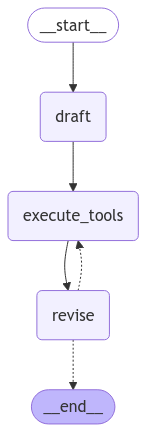

In [98]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Invoke the Agentic System

In [99]:
events = graph.stream(
    {"messages": [("user", "How should we handle the climate crisis?")]},
    stream_mode="values",
)
for i, step in enumerate(events):
    print(f"Step {i}")
    step["messages"][-1].pretty_print()

Step 0
================================ Human Message =================================

How should we handle the climate crisis?
Step 1
================================== Ai Message ==================================
Tool Calls:
  AnswerQuestion (call_yNbEWwuQBZTUaw2lXSgnOaSS)
 Call ID: call_yNbEWwuQBZTUaw2lXSgnOaSS
  Args:
    answer: Addressing the climate crisis requires a multi-faceted approach that combines individual, corporate, and governmental efforts. Here are several critical strategies to handle this pressing issue:

1. **Reducing Greenhouse Gas Emissions**: Transitioning from fossil fuels to renewable energy sources such as solar, wind, and hydropower is essential. Comprehensive policies should be adopted to promote energy efficiency and emission reductions in industries and transportation.

2. **Sustainable Agriculture and Forestry**: Implementing sustainable farming practices and responsible land use can significantly reduce emissions from agriculture. Reforestation and 

In [100]:
events = graph.stream(
    {"messages": [("user", "How to understand the action in Foundational LLM model?")]},
    stream_mode="values",
)
for i, step in enumerate(events):
    print(f"Step {i}")
    step["messages"][-1].pretty_print()

Step 0
================================ Human Message =================================

How to understand the action in Foundational LLM model?
Step 1
================================== Ai Message ==================================
Tool Calls:
  AnswerQuestion (call_3U3brvEZHqpm48VDgv9U01J1)
 Call ID: call_3U3brvEZHqpm48VDgv9U01J1
  Args:
    answer: Understanding the action in Foundational Large Language Models (LLMs) involves several key concepts: model architecture, training process, and inference mechanisms. Foundational LLMs, such as GPT (Generative Pre-trained Transformer), utilize a transformer architecture characterized by self-attention mechanisms. This allows the model to weigh the importance of different words in a sentence, enabling it to capture contextual relationships effectively.

The training process of LLMs involves pre-training on vast amounts of text data to learn language patterns, grammar, facts, and some reasoning abilities. This phase usually employs unsupervis